# Analiza obszarów niezadowolenia firmy McDonald's na podstawie tweetów

**Importowanie bibliotek**

In [ ]:
!pip install pyLDAvis

In [ ]:
import re
from tqdm import tqdm
import os
import json

import tweepy

import nltk
for package in ["punkt", "wordnet", "stopwords"]:
    nltk.download(package)

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances

import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


#### Pobieranie tweetów 

In [ ]:
# Miejsce na wprowadzenie kluczy autoryzacyjnych

consumer_key= 'miejsce klucz'
consumer_secret= 'miejsce na klucz'
access_token= 'miejsce na token'
access_token_secret= 'miejsce na token'

In [ ]:
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

In [ ]:
# Tworzenie ścieżki dostępu do folderu z danymi

directory = os.path.join('data')
if not os.path.exists(directory):
    os.makedirs(directory)
    
output_filepath = os.path.join('data', 'tweets.csv')

In [ ]:
# Tworzenie filtrów 

search_words = "#McDonald's -is:retweet -is:reply -is:quote"
date_since = 'wstaw datę'
date_until = 'wstaw datę'

In [ ]:
# Zapytanie do API

tweets = tw.Cursor(api.search, q=search_words, lang='en', since=date_since, until=date_until, tweet_mode='extended').items(100000)

In [ ]:
tweets_details = [[tweet.user.screen_name, tweet.created_at, tweet.user.location, tweet.full_text] for tweet in tweets]

In [ ]:
tweet_text = pd.DataFrame(data=tweets_details, columns=['user', 'date', 'location', 'text'])
tweet_text.tail()

,user,date,location,text
98176,MoonBae05,2021-05-11 08:16:17,DarkSideoftheMoon,White boy in McDonald’s with ‘waves’ I couldn’...
98177,ahabstanaccount,2021-05-11 08:16:11,UCSD,24 hour gas stations and mcdonald’s drive thru...
98178,NoodleSpoodle1,2021-05-11 08:15:31,,RT @EssexPR: You can go in Costa &amp; McDonal...
98179,BensonJeanloui1,2021-05-11 08:15:09,,@jaspree10531591 @BitMartExchange @safemoon Yo...
98180,coffeemeowk,2021-05-11 08:14:50,⚠️not spoiler-free⚠️,RT @GoodPoliticGuy: They shouldn’t have to be ...


In [ ]:
# Zapisywanie danych do pliku CSV

tweet_text.to_csv(output_filepath, index=False)

In [ ]:
# Dodawanie danych do istniejącego pliku CSV

tweet_text.to_csv(output_filepath, mode='a', index=False, header=False)

#### Projekt

**Wczytywanie danych**

In [ ]:
# Surowe tweety pobierane na początku maja 2021

DATA_LINK = 'https://www.dropbox.com/s/3wi7g83iwrae2v4/tweets.csv?dl=1'
RANDOM_SEED = 2020

In [ ]:
tweet_text_csv = pd.read_csv(DATA_LINK)

In [ ]:
tweet_text_csv = tweet_text_csv.sort_values(by=['date'])
tweet_text_csv = tweet_text_csv.reset_index(drop=True)

In [ ]:
tweet_text_csv

,user,date,location,text
0,wavsurfwav,2021-05-01 00:00:00,NaN,I aint really like WLR that much but I do resp...
1,arran0807,2021-05-01 00:00:05,"London, England",@itadorkis UNO u got McDonald’s and say can I ...
2,Because_Im_Lipi,2021-05-01 00:00:05,B.A.C 05,RT @deadfckingass: mcdonald’s wtf the fuck is ...
3,a_damcx,2021-05-01 00:00:19,"Long Beach, CA",RT @Mangosquash96: @deadfckingass Congratulati...
4,xanieys,2021-05-01 00:00:38,NaN,travis scott had grown men going mcdonald's sa...
...,...,...,...,...
259345,buckleyswartz,2021-05-17 05:53:34,USA,RT @FjdunnR: @rarway @RBReich Interesting that...
259346,KurisuGoji,2021-05-17 05:53:34,"Seattle, WA",RT @myunclesmemes: McDonald's new special http...
259347,my__love__BTS,2021-05-17 05:53:42,그냥 귀엽게 태어난곤뎅,RT @saint: McDonald’s employees have begun rec...
259348,202natt,2021-05-17 05:53:46,"Uptown, DC",@whoisjjcarr McDonald’s is better


In [ ]:
# Sprawdzanie czy dany tweet jest retweetem

tweet_text_csv["is_rt"] = tweet_text_csv["text"].apply(lambda x: "RT @" in x)
tweet_text_csv["is_rt"].value_counts()

True     209249
False     50101
Name: is_rt, dtype: int64

In [ ]:
# Funkcja do czyszczenia retweetów

def removing_RTs(df):
    
    df = df.drop_duplicates(subset=['user', 'date', 'text'], ignore_index=True)
    
    del_pattern = 'RT @'
    filtering_tweets = df['text'].str.contains(del_pattern)
    df = df[~filtering_tweets]
    df = df.reset_index(drop=True)
    
    return df

In [ ]:
tweet_text_csv = removing_RTs(tweet_text_csv)

In [ ]:
tweet_text_csv.shape

(50101, 5)

**Czyszczenie danych**

In [ ]:
# Czyszczenie danych - głównie usunięcie oznaczeń użytkowników i linków

def cleaning_data(df):
    
    df['text'] = df['text'].apply(lambda x : x.replace('@BTS_twt', 'BTS'))
    df['text'] = df['text'].apply(lambda x : re.sub('@\S+', '', x))
    df['text'] = df['text'].apply(lambda x : re.sub('http\S+', '', x))
    df['text'] = df['text'].apply(lambda x : x.replace('\n', ' ')) 
    df['text'] = df['text'].apply(lambda x : x.strip())
    df = df.drop_duplicates(subset=['user', 'text'], ignore_index=True)
    
    return df

<input>:6: DeprecationWarning: invalid escape sequence \S
<input>:6: DeprecationWarning: invalid escape sequence \S
<input>:7: DeprecationWarning: invalid escape sequence \S
<input>:6: DeprecationWarning: invalid escape sequence \S
<input>:7: DeprecationWarning: invalid escape sequence \S
<input>:6: DeprecationWarning: invalid escape sequence \S
<input>:7: DeprecationWarning: invalid escape sequence \S
<input>:6: DeprecationWarning: invalid escape sequence \S
<input>:7: DeprecationWarning: invalid escape sequence \S
<input>:6: DeprecationWarning: invalid escape sequence \S
<input>:7: DeprecationWarning: invalid escape sequence \S
<input>:6: DeprecationWarning: invalid escape sequence \S
<input>:7: DeprecationWarning: invalid escape sequence \S
<ipython-input-11-1cf07d787e51>:6: DeprecationWarning: invalid escape sequence \S
  df['text'] = df['text'].apply(lambda x : re.sub('@\S+', '', x))
<ipython-input-11-1cf07d787e51>:7: DeprecationWarning: invalid escape sequence \S
  df['text'] = d

In [ ]:
cleaning_data(tweet_text_csv)

,user,date,location,text,is_rt
0,wavsurfwav,2021-05-01 00:00:00,NaN,I aint really like WLR that much but I do resp...,False
1,arran0807,2021-05-01 00:00:05,"London, England",UNO u got McDonald’s and say can I have the un...,False
2,xanieys,2021-05-01 00:00:38,NaN,travis scott had grown men going mcdonald's sa...,False
3,fmgsupplychain,2021-05-01 00:00:43,"Chicago, IL",Robust Digital Sales to Drive (MCD) Q1 Earnings,False
4,DoubleDPod,2021-05-01 00:00:48,Your moms house,01:04:26 - Douglas McDonald Vs. The Double D E...,False
...,...,...,...,...,...
49253,doritegrocery,2021-05-17 05:52:24,"Chicago, IL",McDonald's tryna be Lit!,False
49254,WonderG78,2021-05-17 05:52:45,Themyscira or Invisible plane,I understand I cut the cable cord when it beca...,False
49255,jessssyy__,2021-05-17 05:53:00,NaN,Just seen 2 fat rats at McDonald's in kams 😭😭😭...,False
49256,202natt,2021-05-17 05:53:46,"Uptown, DC",McDonald’s is better,False


**Analiza sentymentów**

In [ ]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

def sentiment_analysis(df):
    
    df_sa = df.copy()
    df_sa['scores'] = df_sa['text'].apply(lambda df_sa: sid.polarity_scores(df_sa))
    df_sa['neg'] = df_sa['text'].apply(lambda x:sid.polarity_scores(x)['neg'])
    df_sa['neu'] = df_sa['text'].apply(lambda x:sid.polarity_scores(x)['neu'])
    df_sa['pos'] = df_sa['text'].apply(lambda x:sid.polarity_scores(x)['pos'])
    df_sa['compound']  = df_sa['text'].apply(lambda x:sid.polarity_scores(x)['compound'])
    df_sa['comp_score'] = df_sa['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')
    
    return df_sa

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
tweet_sentiment_analysis = sentiment_analysis(tweet_text_csv)

In [ ]:
tweet_sentiment_analysis[['date', 'text', 'pos', 'neu', 'neg', 'compound', 'comp_score']]

,date,text,pos,neu,neg,compound,comp_score
0,2021-05-01 00:00:00,I aint really like WLR that much but I do resp...,0.125,0.630,0.245,-0.4613,neg
1,2021-05-01 00:00:05,UNO u got McDonald’s and say can I have the un...,0.000,1.000,0.000,0.0000,pos
2,2021-05-01 00:00:38,travis scott had grown men going mcdonald's sa...,0.114,0.886,0.000,0.1695,pos
3,2021-05-01 00:00:43,Robust Digital Sales to Drive (MCD) Q1 Earnings,0.255,0.745,0.000,0.3400,pos
4,2021-05-01 00:00:48,01:04:26 - Douglas McDonald Vs. The Double D E...,0.118,0.659,0.223,-0.7488,neg
...,...,...,...,...,...,...,...
50096,2021-05-17 05:52:27,These 2 are both available on for sale! Check...,0.000,0.721,0.279,-0.6996,neg
50097,2021-05-17 05:52:45,I understand I cut the cable cord when it beca...,0.214,0.710,0.076,0.8478,pos
50098,2021-05-17 05:53:00,Just seen 2 fat rats at McDonald's in kams 😭😭😭...,0.000,1.000,0.000,0.0000,pos
50099,2021-05-17 05:53:46,McDonald’s is better,0.592,0.408,0.000,0.4404,pos


In [ ]:
comp_score = tweet_sentiment_analysis.groupby(['comp_score'])['comp_score'].count()

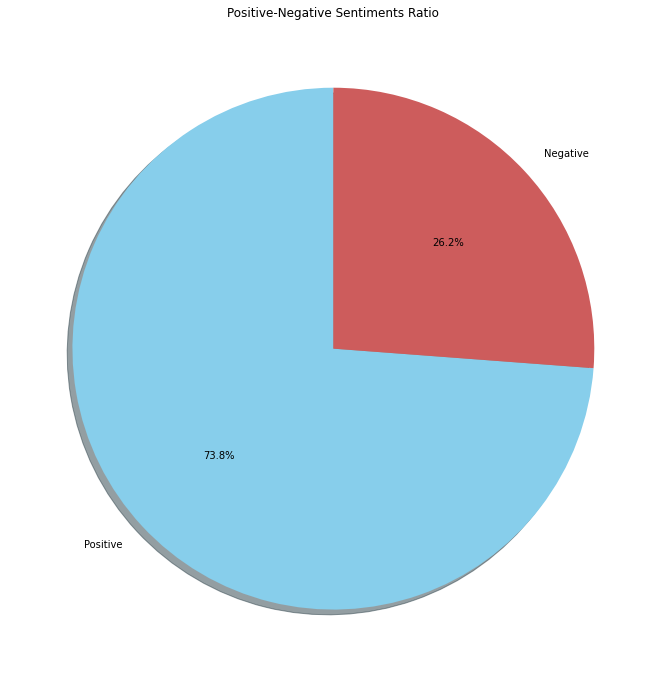

In [ ]:
plt.figure(figsize=(12,12))
plt.title('Positive-Negative Sentiments Ratio')

labels = 'Positive', 'Negative'
sizes = [comp_score[1], comp_score[0]]
colors = 'SkyBlue', 'IndianRed'

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)

plt.show()

**Wyodrębnienie negatywnych tweetów**

In [ ]:
df_neg = tweet_sentiment_analysis.loc[tweet_sentiment_analysis['comp_score']=='neg']
df_neg = df_neg.reset_index(drop=True)
df_neg = df_neg[['user', 'date', 'location', 'text', 'comp_score']]

In [ ]:
df_neg

,user,date,location,text,comp_score
0,wavsurfwav,2021-05-01 00:00:00,NaN,I aint really like WLR that much but I do resp...,neg
1,DoubleDPod,2021-05-01 00:00:48,Your moms house,01:04:26 - Douglas McDonald Vs. The Double D E...,neg
2,takeittobrandon,2021-05-01 00:00:56,"Ohio, USA",The auto business has been dealing with severe...,neg
3,superlameballs,2021-05-01 00:01:01,NaN,"that's definitely the truth, but their fries s...",neg
4,SPOTNEWSonIG,2021-05-01 00:01:29,Chicago IL,79/Phillips: they say a male customer is in th...,neg
...,...,...,...,...,...
13118,thefiances,2021-05-17 05:50:17,NaN,my brother gave me 3 mcdonald’s cookies and sa...,neg
13119,YourTime2Mend,2021-05-17 05:51:02,California,You know the vaccine fucked up if it got McDon...,neg
13120,JoyRoseM,2021-05-17 05:51:56,NaN,That * is doing some heavy lifting. Depending ...,neg
13121,WaveRecords4,2021-05-17 05:52:16,"Los Angeles, CA",McDonald's Sorry for ‘No Blacks Allowed’ Chine...,neg


**Przygotowywanie danych pod dalszą analizę**



1.   Zamiana znaków na małe litery
2.   Usunięcie interpunkcji
3.   Usunięcie słów zawierających liczby
4.   Usunięcie stopwords
5.   Tokenizacja
6.   Usunięcie tokenów krótszych niż 3 litery
7.   Usunięcie niechcianych słów
8.   Lematyzacja



In [ ]:
def preprocess_data(corpus, lemmatizer=WordNetLemmatizer(), stemmer=PorterStemmer()):

    unwanted_tokens = ['shit', 'bitch', 'fuck', 'damn', 'suck', 'nigga']
    
    corpus_preprocessed = []
    for i in tqdm(range(len(corpus))):
        document = corpus[i]
        document_preprocessed = []

        document_cleaned = document.lower()
        document_cleaned = re.sub(r'[^a-zA-Z0-9]', ' ', document_cleaned)
        document_cleaned = re.sub(r'\w*\d\w*', '', document_cleaned)

        for token in word_tokenize(document_cleaned):
            if token not in stopwords.words('english') and len(token) > 3:
                
                if token in unwanted_tokens:
                    continue
                    
                token = lemmatizer.lemmatize(token)
                document_preprocessed.append(token)
        corpus_preprocessed.append(document_preprocessed)

    return corpus_preprocessed

In [ ]:
corpus_preprocessed = preprocess_data(df_neg['text'].values)

100%|██████████| 13123/13123 [00:41<00:00, 319.01it/s]


In [ ]:
def return_tokens(token_list):
    return token_list

bow = CountVectorizer(
    analyzer='word', 
    min_df=15, 
    max_df=0.75, 
    max_features=30000,
    lowercase=False,
    tokenizer=return_tokens
)

bow.fit(corpus_preprocessed)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=False, max_df=0.75, max_features=30000, min_df=15,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function return_tokens at 0x7fcabfff0e60>,
                vocabulary=None)

In [ ]:
corpus_vectorized = bow.fit_transform(corpus_preprocessed)

**Latent Dirichlet Allocation (LDA)**

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:440: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:93: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more d

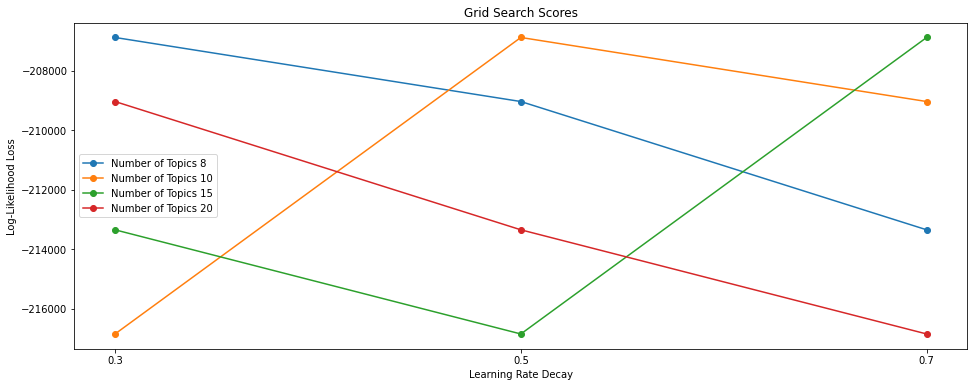

In [ ]:
search_param_space = {
    "n_components": [8, 10, 15, 20], 
    "learning_decay": [0.3, 0.5, 0.7],
    "random_state": [RANDOM_SEED]
}

grid_search = GridSearchCV(
    LatentDirichletAllocation(), 
    param_grid=search_param_space, 
    verbose=1,
    n_jobs=-1,
    cv=3
)
grid_search.fit(corpus_vectorized)

scores = grid_search.cv_results_["mean_test_score"]
scores = np.array(scores).reshape(
    len(search_param_space["n_components"]), len(search_param_space["learning_decay"])
)

fig, ax = plt.subplots(1,1)
fig.set_size_inches(16, 6)

for idx, n in enumerate(search_param_space["n_components"]):
    ax.plot(search_param_space["learning_decay"], scores[idx,:], "-o", 
            label="Number of Topics {}".format(n))
    ax.set_title("Grid Search Scores")
    ax.set_xlabel("Learning Rate Decay")
    ax.set_ylabel("Log-Likelihood Loss")
    ax.set_xticks(search_param_space["learning_decay"])
    ax.legend()
    ax.grid()

In [ ]:
model = grid_search.best_estimator_
corpus_lda = model.transform(corpus_vectorized)

In [ ]:
def color_green(value):
    if isinstance(value, int):
        color = 'black'
    else:
        color = 'green' if value > 0.1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(value):
    if isinstance(value, int):
        weight = 400
    else:
        weight = 700 if value > 0.1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

In [ ]:
df_dominant_topic = pd.DataFrame(
    np.round(corpus_lda, 3),
    columns = ['Topic {}'.format(i) for i in range(model.n_components)],
    index = ['Tweet {}'.format(i) for i in range(len(corpus_lda))]
)
df_dominant_topic['Dominant Topic'] = np.argmax(df_dominant_topic.values, axis=1)
df_dominant_topic.head(20).style.applymap(color_green).applymap(make_bold)

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Dominant Topic
Tweet 0,0.013000,0.013000,0.309000,0.013000,0.203000,0.426000,0.013000,0.013000,5
Tweet 1,0.007000,0.007000,0.251000,0.119000,0.233000,0.007000,0.367000,0.007000,6
Tweet 2,0.007000,0.007000,0.007000,0.007000,0.694000,0.162000,0.007000,0.108000,4
Tweet 3,0.011000,0.011000,0.011000,0.011000,0.011000,0.609000,0.322000,0.011000,5
Tweet 4,0.042000,0.042000,0.042000,0.042000,0.042000,0.042000,0.708000,0.042000,6
Tweet 5,0.781000,0.031000,0.031000,0.031000,0.031000,0.031000,0.031000,0.031000,0
Tweet 6,0.009000,0.009000,0.009000,0.157000,0.293000,0.009000,0.505000,0.009000,6
Tweet 7,0.042000,0.042000,0.042000,0.042000,0.042000,0.042000,0.708000,0.042000,6
Tweet 8,0.016000,0.016000,0.175000,0.016000,0.524000,0.016000,0.223000,0.016000,4
Tweet 9,0.018000,0.875000,0.018000,0.018000,0.018000,0.018000,0.018000,0.018000,1


In [ ]:
# Liczba tweetów przydzielonych do konkretnego tematu

df_topic_distribution = df_dominant_topic["Dominant Topic"].value_counts().to_frame()
df_topic_distribution.index.name = "Topic Id"
df_topic_distribution.columns = ["Tweet Num"]
df_topic_distribution.sort_values(by="Topic Id", inplace=True)

df_topic_distribution

,Tweet Num
Topic Id,
0,1973
1,1281
2,1292
3,1877
4,1674
5,1775
6,1962
7,1289


In [ ]:
cols = 10

df_topic_word_importance = pd.DataFrame(model.components_)
df_topic_word_importance.columns = bow.get_feature_names()
df_topic_word_importance.index = ["Topic {}".format(i) for i in range(model.n_components)]
df_topic_word_importance[df_topic_word_importance.columns[-cols:]].head(model.n_components)

,wrap,write,wrong,yall,yeah,year,yesterday,young,youtube,zero
Topic 0,0.125063,0.125149,4.292429,6.250319,10.849977,84.828157,7.814973,7.067504,0.125020,0.125040
Topic 1,0.125151,0.125046,156.530052,0.125023,2.437000,0.146494,25.687609,0.125099,0.125005,0.125159
Topic 2,0.125005,11.714201,2.342352,0.125025,73.034081,13.815776,5.098812,0.125183,17.053486,5.302569
Topic 3,0.125249,3.340171,1.447211,19.087187,0.125131,12.769857,5.598225,7.485127,0.125117,16.897069
Topic 4,0.125020,0.125346,15.058655,0.125086,1.948456,75.478212,0.125114,5.907420,0.125167,0.125248
Topic 5,0.125051,0.319925,32.930274,0.125087,0.165095,71.924433,5.425029,0.125133,0.125034,0.125166
Topic 6,0.125015,0.125106,13.273937,0.125116,0.125118,185.911936,0.125093,17.039506,0.125055,0.125227
Topic 7,38.124446,0.125055,0.125090,7.037157,22.315141,0.125135,0.125144,0.125027,2.196116,6.174523


In [ ]:
# 8 najważniejszych tematów przewodnich wygenerowanych na podstawie tweetów

top_keywords_num = 6

top_keywords_indices = np.argsort(df_topic_word_importance.values)[:, -top_keywords_num:][:, ::-1]

df_top_keywords = pd.DataFrame(
    np.array(bow.get_feature_names())[top_keywords_indices],
    columns = ["Word {}".format(i) for i in range(top_keywords_num)],
    index = ["Topic {}".format(i) for i in range(model.n_components)]
)

df_top_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5
Topic 0,drive,time,like,thru,girl,parking
Topic 1,order,fire,cry,meal,said,check
Topic 2,machine,cream,always,broken,know,broke
Topic 3,food,breakfast,sprite,coffee,fucking,good
Topic 4,people,wage,worker,hour,employee,minimum
Topic 5,burger,think,fry,going,time,king
Topic 6,work,hate,people,year,stop,would
Topic 7,chicken,sandwich,boycott,photo,would,like


Na podstawie słów kluczowych przydzielonych do każdego z tematów, wskazać można główne obszary niezadowolenia klientów oraz/i pracowników firmy McDonald's:

*  Temat 0: Drive-thru
*  Temat 2: Popsuta maszyna do lodów
*  Temat 3: Usunięcie całodobowej oferty śniadaniowej w USA
*  Temat 4: Zarobki pracowników
*  Temat 7: Bojkot klientów McDonald's związany z ruchem wyswobodzenia Palestyny